<a href="https://colab.research.google.com/github/yuchu1996/stackoverflow/blob/master/boston_airbnb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from datetime import datetime, timedelta
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

In [2]:
 from google.colab import drive 
 drive.mount('/content/gdrive') 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [5]:

%matplotlib inline

df = pd.read_csv('/content/gdrive/My Drive/listings.csv')
df.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,...,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",NaN,"The bus stop is 2 blocks away, and frequent. B...","You will have access to 2 bedrooms, a living r...",NaN,Clean up and treat the home the way you'd like...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,31303940,https://www.airbnb.com/users/show/31303940,Virginia,2015-04-15,"Boston, Massachusetts, United States",We are country and city connecting in our deck...,NaN,NaN,NaN,f,https://a2.muscache.com/im/pictures/5936fef0-b...,https://a2.muscache.com/im/pictures/5936fef0-b...,Roslindale,1,1,"['email', 'phone', 'facebook', 'reviews']",t,f,"Birch Street, Boston, MA 02131, United States",Roslindale,Roslindale,...,2.0,3.0,Real Bed,"{TV,""Wireless Internet"",Kitchen,""Free Parking ...",NaN,$250.00,NaN,NaN,NaN,$35.00,1,$0.00,2,1125,2 weeks ago,NaN,0,0,0,0,2016-09-06,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,NaN,NaN,f,moderate,f,f,1,NaN
1,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...","If you don't have a US cell phone, you can tex...",Plenty of safe street parking. Bus stops a few...,Apt has one more bedroom (which I use) and lar...,"If I am at home, I am likely working in my hom...",Pet friendly but please confirm with me if the...,https://a1.muscache.com/im/pictures/39327812/d...,https://a1.muscache.com/im/pictures/39327812/d...,https://a1.muscache.com/im/pictures/39327812/d...,https://a1.muscache.com/im/pictures/39327812/d...,2572247,https://www.airbnb.com/users/show/2572247,Andrea,2012-06-07,"Boston, Massachusetts, United States",I live in Boston and I like to travel and have...,within an hour,100%,100%,f,https://a2.muscache.com/im/users/2572247/profi...,https://a2.muscache.com/im/users/2572247/profi...,Roslindale,1,1,"['email', 'phone', 'facebook', 'linkedin', 'am...",t,t,"Pinehurst Street, Boston, MA 02131, United States",Roslindale,Roslindale,...,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",""Air Conditio...",NaN,$65.00,$400.00,NaN,$95.00,$10.00,0,$0.00,2,15,a week ago,NaN,26,54,84,359,2016-09-06,36,2014-06-01,2016-08-13,94.0,10.0,9.0,10.0,10.0,9.0,9.0,f,NaN,NaN,t,moderate,f,f,1

In [6]:
df.shape

(3585, 95)

In [8]:
## include important columns only
col_list = ['id', 'host_since', 'neighbourhood', 'host_total_listings_count', 'bedrooms', 'beds', 'bed_type', 'square_feet', 'cleaning_fee', 
            'guests_included', 'minimum_nights', 'maximum_nights', 'number_of_reviews', 'review_scores_rating', 'reviews_per_month', 'cancellation_policy', 
            'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
            'review_scores_value', 'price']

df = df[col_list]

df.shape


(3585, 23)

In [9]:
## see the numeric vars
df.describe()

,id,host_total_listings_count,bedrooms,beds,square_feet,guests_included,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,reviews_per_month,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
count,3.585000e+03,3585.000000,3575.000000,3576.000000,56.000000,3585.000000,3585.000000,3.585000e+03,3585.000000,2772.000000,2829.000000,2762.000000,2767.000000,2765.000000,2767.000000,2763.000000,2764.000000
mean,8.440875e+06,58.902371,1.255944,1.609060,858.464286,1.429847,3.171269,2.872584e+04,19.044630,91.916667,1.970908,9.431571,9.258041,9.646293,9.646549,9.414043,9.168234
std,4.500787e+06,171.119663,0.753060,1.011745,608.874310,1.056787,8.874133,1.670136e+06,35.571658,9.531686,2.120561,0.931863,1.168977,0.762753,0.735507,0.903436,1.011116
min,3.353000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000e+00,0.000000,20.000000,0.010000,2.000000,2.000000,2.000000,4.000000,2.000000,2.000000
25%,4.679319e+06,1.000000,1.000000,1.000000,415.000000,1.000000,1.000000,3.650000e+02,1.000000,89.000000,0.480000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000
50%,8.577620e+06,2.000000,1.000000,1.000000,825.000000,1.000000,2.000000,1.125000e+03,5.000000,94.000000,1.170000,10.000000,10.000000,10.000000,10.000000,10.000000,9.000000
75%,1.278953e+07,7.000000,2.000000,2.000000,1200.000000,1.000000,3.000000,1.125000e+03,21.000000,98.250000,2.720000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
max,1.493346e+07,749.000000,5.000000,16.000000,2400.000000,14.000000,300.000000,1.000000e+08,404.000000,100.000000,19.150000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000


In [15]:
cat_df = df.select_dtypes(include = ['object'])
# Print how many categorical columns are in the dataframe -- 6
cat_df

,host_since,neighbourhood,bed_type,cleaning_fee,cancellation_policy,price
0,2015-04-15,Roslindale,Real Bed,$35.00,moderate,$250.00
1,2012-06-07,Roslindale,Real Bed,$10.00,moderate,$65.00
2,2009-05-11,Roslindale,Real Bed,NaN,moderate,$65.00
3,2013-04-21,NaN,Real Bed,$50.00,moderate,$75.00
4,2014-05-11,Roslindale,Real Bed,$15.00,flexible,$79.00
...,...,...,...,...,...,...
3580,2014-07-31,Somerville,Real Bed,NaN,strict,$69.00
3581,2015-07-02,NaN,Real Bed,$15.00,strict,$150.00
3582,2014-01-14,NaN,Real Bed,NaN,flexible,$198.00
3583,2016-05-27,Somerville,Real Bed,NaN,strict,$65.00


In [0]:
## modeification 
# delete the dolar sign
df['price'] =  df['price'].str.replace(r'\D', '').apply(pd.to_numeric)
df['cleaning_fee'] =  df['cleaning_fee'].str.replace(r'\D', '').apply(pd.to_numeric)
# transform the date into days
df['host_since']= pd.to_datetime(df['host_since'])

now = datetime.now()
days = lambda col: (now - col).days
df['host_since'] = df['host_since'].apply(days)

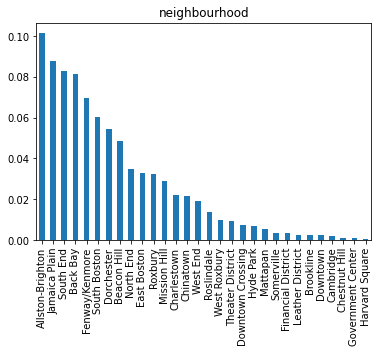

In [45]:
count_vals = df.neighbourhood.value_counts()#Provide a pandas series of the counts for each Country

# The below should be a bar chart of the proportion of the top 10 countries for the
# individuals in your count_vals if it is set up correctly.

(count_vals/df.shape[0]).plot(kind="bar");
plt.title("neighbourhood");

In [0]:
def clean_data(df):
    ## delete the columns with too many missing values
    try: 
      most_missing_cols = set(df.columns[df.isnull().mean()>0.75])
      df = df.drop(most_missing_cols, axis = 1)
    except:
      print("No columns with more than 75% missing")
    
    ## set x, y 
    df = df.dropna(subset = ['price'])
    X = df.drop(['price'], axis = 1)
    y = df['price']

    ## imputation for numeric columns
    ## get dummies for categorical columns
    fillna = lambda col: col.fillna(col.mode()[0])
    for col in X.columns:
        if X.dtypes[col] == np.object:
            X = pd.concat([X.drop(col, axis = 1), pd.get_dummies(X[col], prefix=col, prefix_sep='_', drop_first=True)], axis=1)
        else:
            X[col] = X[col].fillna(X[col].mean())
    
    return X, y
    
#Use the function to create X and y
X, y = clean_data(df)

In [46]:
y

0       25000
1        6500
2        6500
3        7500
4        7900
        ...  
3580     6900
3581    15000
3582    19800
3583     6500
3584     6500
Name: price, Length: 3585, dtype: int64

In [0]:
class boston:
  def __init__(self, df):  
        self.df = df    
        self.dim = df.shape

  def __repr__(self):
        return '__repr__ for boston'

  def clean_data(self):
    '''
    this function is to clean the data set including :
    - delete the columns with more than 75% missing values;
    - for numeric columns: impute the mode into the missing rows;
    - for categorical columns: get dummies to transform the columns into encoding;
    - finally assign the columns to X, y dataframe for further analysis
    - print "done!"

    '''
    ## delete the columns with too many missing values
    try: 
      most_missing_cols = set(self.df.columns[df.isnull().mean()>0.75])
      self.df = self.df.drop(most_missing_cols, axis = 1)
    except:
      print("No columns with more than 75% missing")
    
    ## set x, y 
    self.df = self.df.dropna(subset = ['price'])
    X = self.df.drop(['price'], axis = 1)
    y = self.df['price']

    ## imputation for numeric columns
    ## get dummies for categorical columns
    fillna = lambda col: col.fillna(col.mode()[0])
    for col in X.columns:
        if X.dtypes[col] == np.object:
            X = pd.concat([X.drop(col, axis = 1), pd.get_dummies(X[col], prefix=col, prefix_sep='_', drop_first=True)], axis=1)
        else:
            X[col] = X[col].fillna(X[col].mean())
    print("assign data to x,y after cleaning!")
    return X, y

  def xgb_mod(self, test_size=.3, rand_state=42):
    '''
    this function
    input: a dataframe, test_size for splitting and randon seeds number

    output: the XGBoost model, r-squared score for the model, train and test datasets after splitting

    '''
    X, y = clean_data(self.df)
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state=rand_state) 

    tf = XGBRegressor(n_estimators=700).fit(X_train, y_train) # Instantiate
     #Fit
        
    #Predict and score the model
    y_test_preds = tf.predict(X_test) 
    test_score = r2_score(y_test, y_test_preds)
    
    return test_score, tf, X_train, X_test, y_train, y_test

In [87]:
p = boston(df)  
X, y = p.clean_data()

assign data to x,y after cleaning!


In [93]:
p = boston(df)
test_score, lm_model, X_train, X_test, y_train, y_test = p.linear_mod(.3, 42)

[03:10:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [94]:
test_score

0.22492939898483322

In [103]:
p = boston(df)
print(p)
repr(p)

__repr__ for boston


'__repr__ for boston'